In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as dates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt


import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# Preprocessing

In [3]:
df = pd.read_csv('../data/raw/Processed_NYSE.csv', delimiter=',')
df.head()

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,7184.959961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,7326.740234,0.921723,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,7354.870117,-0.375903,0.003839,0.019733,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,7377.700195,0.996234,0.003104,0.003839,0.019733,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,7393.930176,0.059932,0.002200,0.003104,0.003839,0.019733,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


Заполняем пропущенные значения средним по признаку

In [4]:
df = df.fillna(df.mean())
df.drop(df.columns[58], axis='columns', inplace = True)
df.head()

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,7184.959961,0.013520,0.000316,0.000318,0.000320,0.000320,0.152682,0.29822,0.450697,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,7326.740234,0.921723,0.019733,0.000318,0.000320,0.000320,0.152682,0.29822,0.450697,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,7354.870117,-0.375903,0.003839,0.019733,0.000320,0.000320,0.152682,0.29822,0.450697,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,7377.700195,0.996234,0.003104,0.003839,0.019733,0.000320,0.152682,0.29822,0.450697,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,7393.930176,0.059932,0.002200,0.003104,0.003839,0.019733,0.152682,0.29822,0.450697,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [5]:
Y = df['Close']

data = df.copy()
del data['Date']

In [6]:
data.head()

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,7184.959961,0.013520,0.000316,0.000318,0.000320,0.000320,0.152682,0.29822,0.450697,0.611981,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,7326.740234,0.921723,0.019733,0.000318,0.000320,0.000320,0.152682,0.29822,0.450697,0.611981,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,7354.870117,-0.375903,0.003839,0.019733,0.000320,0.000320,0.152682,0.29822,0.450697,0.611981,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,7377.700195,0.996234,0.003104,0.003839,0.019733,0.000320,0.152682,0.29822,0.450697,0.611981,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,7393.930176,0.059932,0.002200,0.003104,0.003839,0.019733,0.152682,0.29822,0.450697,0.611981,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [7]:
Y.head()

0    7184.959961
1    7326.740234
2    7354.870117
3    7377.700195
4    7393.930176
Name: Close, dtype: float64

# Data normalization

In [8]:
def train_val_test(X,Y, val_size, test_size):
    p1 = int(len(X) * (1 - val_size - test_size))
    p2 = int(len(X) * (val_size)) + p1
    
    X_train, X_val, X_test = X[:p1], X[p1:p2], X[p2:]
    
    y_train, y_val, y_test = Y[:p1], Y[p1:p2], Y[p2:]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
X_train_orig, X_val_orig, X_test_orig, y_train_orig, y_val_orig, y_test_orig= train_val_test(data, Y, val_size=0, test_size=0.2)

scale_x = MinMaxScaler(feature_range = (0, 1))
X_train = scale_x.fit_transform(X_train_orig)
X_test = scale_x.transform(X_test_orig)

# scale_y = MinMaxScaler(feature_range = (0, 1))
# y_train = scale_y.fit_transform(y_train_orig.to_numpy().reshape(-1,1))
# y_test = scale_y.transform(y_test_orig.to_numpy().reshape(-1,1))

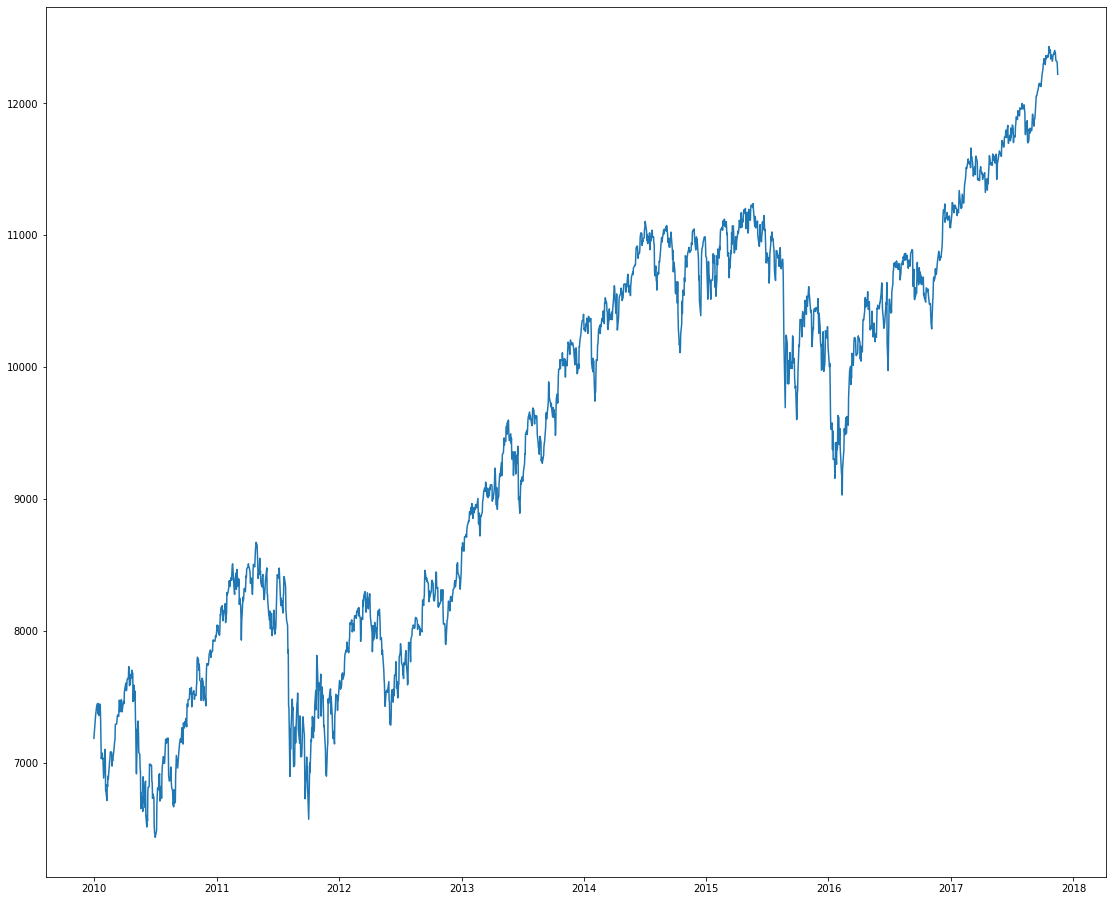

In [10]:
dates = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in df['Date']]
fig = plt.figure(figsize = (19,16))
plt.plot(dates, Y)
plt.show()

# Regression

In [104]:
def make_features(X, seq_len):
    x_res = []
    for i in range(seq_len, len(X)):
        x_res.append(X[i-seq_len:i])
    return np.array(x_res)
        
def make_labels(y, seq_len):
    y_res = []
    for i in range(seq_len, len(y)):
        y_res.append(y[i])
    return np.array(y_res)

def make_labels2(y, seq_len):
    y_res = []
    for i in range(seq_len, len(y)):
        y_res.append(y[i]/(y[i-seq_len] + 0.001))
    
#     y_seq = y[seq_len+1:]
#     print (y_seq.shape)
#     y_res = [y[seq_len] / (y[seq_len]+0.001)-1] + [curr / (y_seq[i] + 0.001)-1 for i, curr in enumerate(y_seq)]
    return np.array(y_res)

In [105]:
seq_len = 10

X_train = make_features(X_train, seq_len)
X_test = make_features(X_test, seq_len)


y_train = make_labels2(y_train_orig.to_numpy().reshape(-1,1), seq_len)
y_test = make_labels2(y_test_orig.to_numpy().reshape(-1,1), seq_len)

In [106]:
scale_y = MinMaxScaler(feature_range = (0, 1))
y_train = scale_y.fit_transform(y_train)
y_test = scale_y.transform(y_test)

In [107]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1577, 10, 82) (1577, 1)
(387, 10, 82) (387, 1)


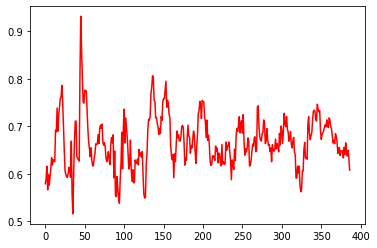

In [108]:
plt.plot(range(len(y_test)), y_test, color = 'red')
# plt.legend()
plt.show()

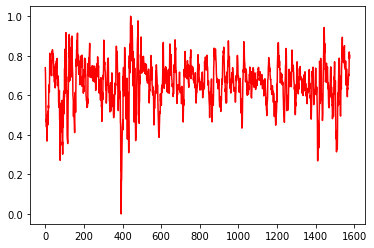

In [109]:
plt.plot(range(len(y_train)), y_train, color = 'red')
# plt.legend()
plt.show()

In [110]:
# Y = [Y[0] / (Y[0]+0.001)-1] + [curr / (Y[i] + 0.001)-1 for i, curr in enumerate(Y[1:])]

# # Split into groups of `num_steps`
# X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
# y = np.array([Y[i + num_steps] for i in range(len(Y) - num_steps)])

# Training 

Check GPU availibility

In [67]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU')) > 0

True

In [68]:
def lstm1():
    model = Sequential()
    model.add(LSTM(256, input_shape=(seq_len, 82), dropout=0.2, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    return model

In [69]:
def lstm3():
    model = Sequential()
    model.add(LSTM(128, input_shape=(seq_len, 82), dropout=0.1, return_sequences=True))
    model.add(tf.keras.layers.GRU(128, input_shape=(seq_len,128), dropout=0.2, return_sequences=True))
    model.add(LSTM(64, input_shape=(seq_len,128) , dropout=0.2))
    model.add(Dense(64))
    model.add(Dense(1))
    return model

In [70]:
def scheduler(epoch, lr):
    if epoch % 20 == 0:
        return lr * 0.5
    else:
        return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [71]:
model = lstm3()
adam = Adam(lr=0.001)
model_chk_path = 'best_model.pkl'
chk = ModelCheckpoint(model_chk_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model.compile(loss='mean_absolute_error', optimizer=adam)

In [72]:
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[callback, chk], validation_data=(X_test,y_test))

Epoch 1/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1130
Epoch 00001: val_loss improved from inf to 0.03942, saving model to best_model.pkl
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model.pkl\assets
50/50 [==============================] - 26s 511ms/step - loss: 0.1120 - val_loss: 0.0394
Epoch 2/100
43/50 [========================>.....] - ETA: 0s - loss: 0.0747
Epoch 00002: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0748 - val_loss: 0.0491
Epoch 3/100
45/50 [==========================>...] - ETA: 0s - loss: 0.0710
Epoch 00003: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0700 - val_loss: 0.0448
Epoch 4/100
44/50 [=============

42/50 [========================>.....] - ETA: 0s - loss: 0.0527
Epoch 00035: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0532 - val_loss: 0.0948
Epoch 36/100
40/50 [=======================>......] - ETA: 0s - loss: 0.0555
Epoch 00036: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0552 - val_loss: 0.0859
Epoch 37/100
44/50 [=========================>....] - ETA: 0s - loss: 0.0500
Epoch 00037: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0512 - val_loss: 0.0433
Epoch 38/100
43/50 [========================>.....] - ETA: 0s - loss: 0.0509
Epoch 00038: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0503 - val_loss: 0.0577
Epoch 39/100
43/50 [========================>.....] - ETA: 0s - loss: 0.0476
Epoch 00039: val_loss did not improve from 0.03942
50/50 [==================

44/50 [=========================>....] - ETA: 0s - loss: 0.0477
Epoch 00073: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0472 - val_loss: 0.0533
Epoch 74/100
45/50 [==========================>...] - ETA: 0s - loss: 0.0460
Epoch 00074: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.0604
Epoch 75/100
44/50 [=========================>....] - ETA: 0s - loss: 0.0452
Epoch 00075: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0454 - val_loss: 0.0573
Epoch 76/100
44/50 [=========================>....] - ETA: 0s - loss: 0.0455
Epoch 00076: val_loss did not improve from 0.03942
50/50 [==============================] - 0s 6ms/step - loss: 0.0453 - val_loss: 0.0557
Epoch 77/100
45/50 [==========================>...] - ETA: 0s - loss: 0.0458
Epoch 00077: val_loss did not improve from 0.03942
50/50 [==================

# Prediction

In [83]:
loaded_model = tf.keras.models.load_model(model_chk_path)

In [84]:
def origin_result(model, y,y_orig,seq_len, scaler):
    y_res = []
    y_orig = y_orig.to_numpy()
    tmp = (y / scaler.scale_) + scaler.data_min_
    for i in range(seq_len, len(y_orig)):
        y_res.append(tmp[i-seq_len]*y_orig[i-seq_len])
    return y_res

In [111]:
y_pred = model.predict(X_test)
y_orig_scale =  origin_result(loaded_model, y_pred,y_test_orig,seq_len, scale_y)

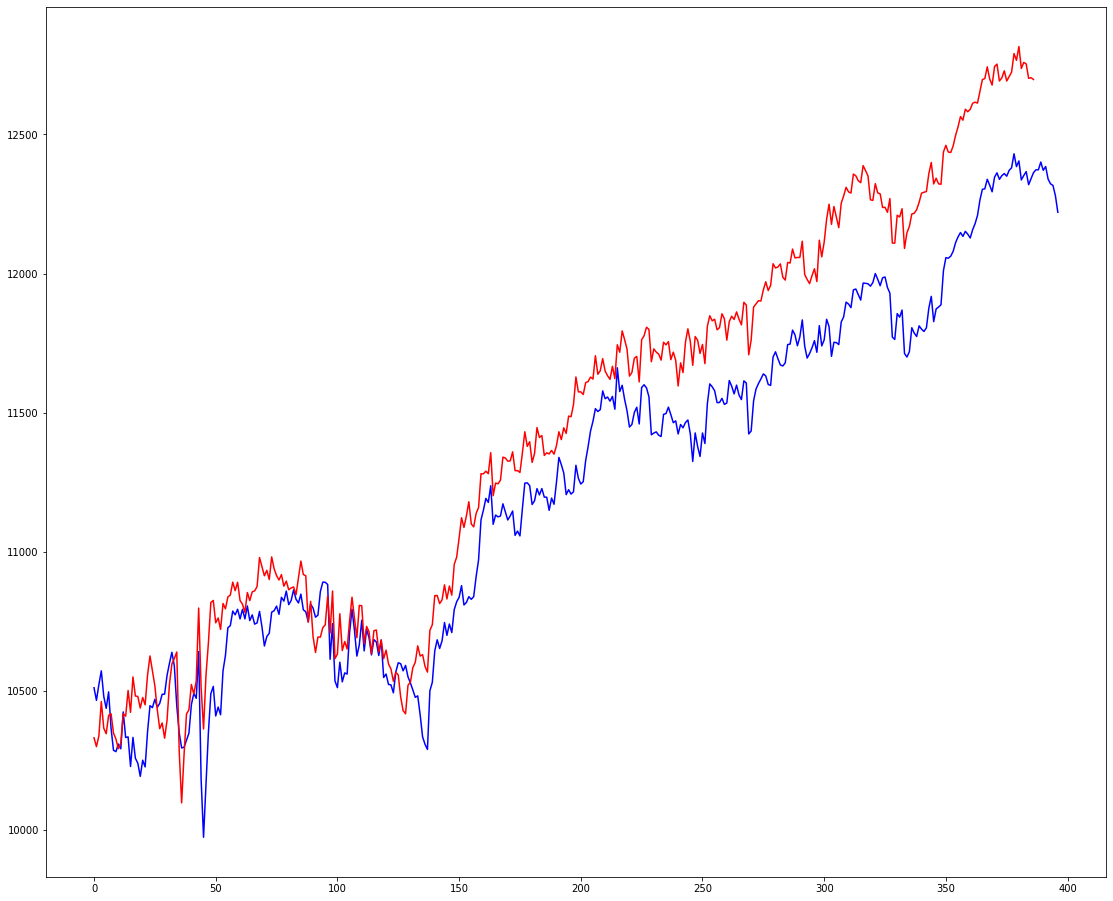

In [76]:
fig = plt.figure(figsize = (19,16))
plt.plot(range(len(y_test_orig)), y_test_orig, color='blue')
plt.plot(range(len(y_orig_scale)), y_orig_scale, color = 'red')
# plt.legend()
plt.show()

# Regression results

In [115]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print ("RMSE: " ,np.sqrt(mean_squared_error( y_test, loaded_model(X_test))))
print ("MAE: " ,mean_absolute_error(y_test, loaded_model(X_test)))

RMSE:  0.05008993699224595
MAE:  0.03942160757982894


# Classification $(Close_{t+seq\ len} > Close_t)$

In [116]:
def make_labels_clf(y):
    y_res = []
    for i in range(seq_len, len(y)):
        y_res.append(y[i] > y[i-seq_len])
    return np.array(y_res, dtype=int)

def make_features(X, seq_len):
    x_res = []
    for i in range(seq_len, len(X)):
        x_res.append(X[i-seq_len:i])
    return np.array(x_res)

scale_x = StandardScaler()
X_train = scale_x.fit_transform(X_train_orig)
X_test = scale_x.transform(X_test_orig)

seq_len = 50

X_train = make_features(X_train, seq_len)
X_test = make_features(X_test, seq_len)

y_train = make_labels_clf(y_train_orig.to_numpy().reshape(-1,1))
y_test = make_labels_clf(y_test_orig.to_numpy().reshape(-1,1))        

In [117]:
def lstm_clf():
    model = Sequential()
    model.add(LSTM(128, input_shape=(seq_len, 82), dropout=0.5, return_sequences=True))
    model.add(tf.keras.layers.GRU(128, input_shape=(seq_len,128), dropout=0.5, return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(LSTM(64, input_shape=(seq_len,128) , dropout=0.5))
    model.add(Dense(32))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [118]:
def lstm_clf1():
    model = Sequential()
    model.add(LSTM(256, input_shape=(seq_len, 82), dropout=0.2, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [120]:
model_clf = lstm_clf()
adam_clf = Adam(lr=0.001)
model_chk_path_clf = 'best_model_clf.pkl'
chk_clf = ModelCheckpoint(model_chk_path_clf, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model_clf.compile(loss='binary_crossentropy', optimizer=adam_clf, metrics=['accuracy'])
model_clf.fit(X_train, y_train, epochs=100, batch_size=128, callbacks=[chk_clf], validation_data=(X_test,y_test))

Epoch 1/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.5302 - accuracy: 0.7274
Epoch 00001: val_accuracy improved from -inf to 0.83573, saving model to best_model_clf.pkl
INFO:tensorflow:Assets written to: best_model_clf.pkl\assets
13/13 [==============================] - 27s 2s/step - loss: 0.5092 - accuracy: 0.7430 - val_loss: 0.3592 - val_accuracy: 0.8357
Epoch 2/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.3588 - accuracy: 0.8359
Epoch 00002: val_accuracy did not improve from 0.83573
13/13 [==============================] - 0s 14ms/step - loss: 0.3621 - accuracy: 0.8380 - val_loss: 0.3730 - val_accuracy: 0.8357
Epoch 3/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.3410 - accuracy: 0.8516
Epoch 00003: val_accuracy improved from 0.83573 to 0.89337, saving model to best_model_clf.pkl
INFO:tensorflow:Assets written to: best_model_clf.pkl\assets
13/13 [==============================] - 26s 2s/step - loss: 0.3290 - accuracy: 0.8608 - val

Epoch 29/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1597 - accuracy: 0.9361
Epoch 00029: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 13ms/step - loss: 0.1612 - accuracy: 0.9369 - val_loss: 0.3912 - val_accuracy: 0.8905
Epoch 30/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1919 - accuracy: 0.9254
Epoch 00030: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 13ms/step - loss: 0.1911 - accuracy: 0.9258 - val_loss: 0.4832 - val_accuracy: 0.8732
Epoch 31/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1679 - accuracy: 0.9240
Epoch 00031: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 14ms/step - loss: 0.1734 - accuracy: 0.9219 - val_loss: 0.4081 - val_accuracy: 0.8761
Epoch 32/100
11/13 [========================>.....] - ETA: 0s - loss: 0.2436 - accuracy: 0.8956
Epoch 00032: val_accuracy did not improve from 0.90778
13/13 

10/13 [======================>.......] - ETA: 0s - loss: 0.1442 - accuracy: 0.9344
Epoch 00058: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 14ms/step - loss: 0.1548 - accuracy: 0.9258 - val_loss: 0.7764 - val_accuracy: 0.8329
Epoch 59/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.1315 - accuracy: 0.9470
Epoch 00059: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 14ms/step - loss: 0.1320 - accuracy: 0.9473 - val_loss: 0.7393 - val_accuracy: 0.8329
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1478 - accuracy: 0.9368
Epoch 00060: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 16ms/step - loss: 0.1483 - accuracy: 0.9362 - val_loss: 0.7896 - val_accuracy: 0.8357
Epoch 61/100
10/13 [======================>.......] - ETA: 0s - loss: 0.2086 - accuracy: 0.9156
Epoch 00061: val_accuracy did not improve from 0.90778
13/13 [============

10/13 [======================>.......] - ETA: 0s - loss: 0.1565 - accuracy: 0.9336
Epoch 00087: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 13ms/step - loss: 0.1657 - accuracy: 0.9297 - val_loss: 0.8790 - val_accuracy: 0.6484
Epoch 88/100
11/13 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 0.9126
Epoch 00088: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 13ms/step - loss: 0.2041 - accuracy: 0.9122 - val_loss: 0.5905 - val_accuracy: 0.8012
Epoch 89/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1952 - accuracy: 0.9119
Epoch 00089: val_accuracy did not improve from 0.90778
13/13 [==============================] - 0s 13ms/step - loss: 0.1970 - accuracy: 0.9076 - val_loss: 0.4988 - val_accuracy: 0.8588
Epoch 90/100
11/13 [========================>.....] - ETA: 0s - loss: 0.1853 - accuracy: 0.9205
Epoch 00090: val_accuracy did not improve from 0.90778
13/13 [============

In [129]:
def predict(y):
    return np.array(y>0.5,dtype=int)

In [131]:
loaded_model = tf.keras.models.load_model(model_chk_path_clf)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print ("Accuracy: " ,accuracy_score(y_test, predict(loaded_model(X_test))))
print ("F1 score: " ,f1_score(y_test, predict(loaded_model(X_test)), average='macro'))
print ("Precision: " ,precision_score(y_test, predict(loaded_model(X_test))))
print ("Recall: " ,recall_score(y_test, predict(loaded_model(X_test))))

Accuracy:  0.9077809798270894
F1 score:  0.8320629159104658
Precision:  0.9448275862068966
Recall:  0.9448275862068966
